# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do we `get our own data` into PyTorch?

One of the ways to do so is via `Custom Datasets`

We are going to build `FoodVision Mini` in this chapter.

## What we're going to cover

1. Getting a `custom dataset` with PyTorch
2. `Becoming one with the data` - preparing and visualizing
3. `Transforming data` for use with a model
4. `Loading custom data` with pre-built functions and custom functions
5. Building `FoodVision Mini` to classify food images.
6. Comparing models with and without `data augmentation`
7. `Making predictions` on custom data.

## 0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn


device = 'gpu' if torch.cuda.is_available() else 'cpu'

print('PyTorch version: ', torch.__version__)
print('Available device: ', device)

PyTorch version:  2.0.1
Available device:  cpu


## 1. Get data

Our dataset is a subset of the `Food101 dataset`.

Food101 dataset has 101 different classes of food with 1000 images per class(750 training, 250 testing)

`Our dataset` stars with `3 classes of food` and only `10% of the images(~75 training, 25 testing)`

`Why do this?`

When `starting` out ML projects, it's important to try things on a `small` scale and then `increase` the scale `when necessary`.

`The whole point is to spped up the experiment`

In [2]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if image folder doesn't exist, download and prepare it
if image_path.is_dir():
    print(f'{image_path} directory already exists. Skipping download')
else:
    print(f'{image_path} does not exist, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
data_url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
data_file_name = data_url.split('/')[-1]
download_file_path = data_path / data_file_name # 'pizza_steak_sushi.zip'

with open(download_file_path, 'wb') as f:
    request = requests.get(data_url)
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(download_file_path, 'r') as zip_ref:
    print('Unzipping the data')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists. Skipping download
Unzipping the data


In [3]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [4]:
# Path(glob.glob(f'{str(train_dir)}/*/*')[0]).parent.stem

### 2.1 Visualizing the image

1. Get all of the images paths
2. pick random image path using Python's random.choice()
3. Get the image class name using `pathlib.path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata.

300
data/pizza_steak_sushi/train/sushi/385154.jpg
Random Image path: data/pizza_steak_sushi/train/sushi/385154.jpg
Image class: sushi
Image height: 382
Image width: 512


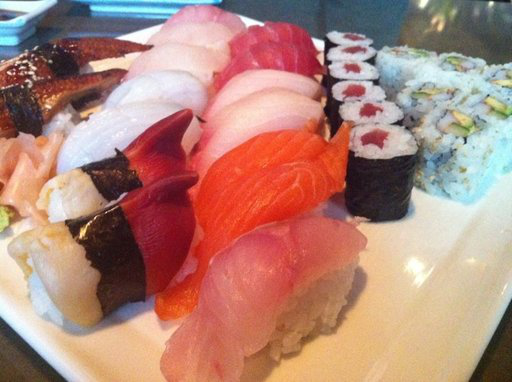

In [5]:
import random
from PIL import Image
from IPython import display

# set seed
# random.seed(42)

# 1. Get all the images paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
print(len(image_path_list))

# 2. pick a random image path

random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
image_class

# 4. Open Image
img = Image.open(random_image_path)

# # 5. Print metadata
print(f'Random Image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

### 2.2 Visualizing with Matplotlib

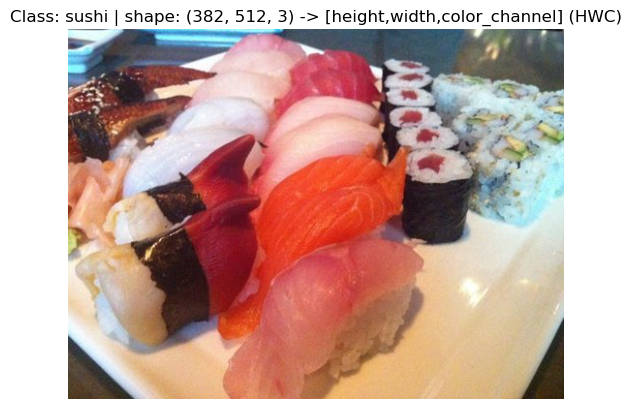

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into array
images_as_array = np.asarray(img)

# plt.figure(figsize=(10,7))
plt.imshow(images_as_array);
plt.title(f'Class: {image_class} | shape: {images_as_array.shape} -> [height,width,color_channel] (HWC)')
plt.axis(False);

In [7]:
images_as_array

array([[[141, 171, 179],
        [141, 170, 176],
        [138, 167, 173],
        ...,
        [ 26,  32,  30],
        [ 64,  70,  68],
        [114, 120, 116]],

       [[209, 242, 249],
        [211, 244, 251],
        [213, 244, 249],
        ...,
        [ 26,  32,  32],
        [ 56,  62,  60],
        [ 98, 104, 102]],

       [[208, 247, 254],
        [213, 250, 255],
        [216, 253, 255],
        ...,
        [ 51,  59,  61],
        [ 71,  77,  77],
        [102, 108, 108]],

       ...,

       [[ 77,  60,  32],
        [ 79,  59,  34],
        [ 80,  60,  35],
        ...,
        [ 49,  32,  12],
        [ 47,  30,  10],
        [ 51,  34,  14]],

       [[ 77,  57,  30],
        [ 76,  56,  31],
        [ 77,  57,  32],
        ...,
        [ 47,  29,   9],
        [ 46,  28,   8],
        [ 54,  36,  16]],

       [[ 73,  53,  26],
        [ 73,  53,  28],
        [ 74,  54,  29],
        ...,
        [ 57,  36,  17],
        [ 50,  29,  10],
        [ 55,  34,  15]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical represenation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

In [9]:
# write a transform for image
data_transforms = transforms.Compose([
    # resize our image to 64x64
    transforms.Resize(size=(64,64)),
    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # convert to tensor
    transforms.ToTensor()
])

# transform the img we loaded before
data_transforms(img)

tensor([[[0.8118, 0.8431, 0.8392,  ..., 0.5216, 0.3137, 0.2824],
         [0.6745, 0.7765, 0.8314,  ..., 0.4392, 0.3451, 0.3333],
         [0.3686, 0.4471, 0.6471,  ..., 0.3412, 0.3059, 0.3412],
         ...,
         [0.3255, 0.3373, 0.3490,  ..., 0.2314, 0.2314, 0.2196],
         [0.3216, 0.3333, 0.3294,  ..., 0.2471, 0.2353, 0.2157],
         [0.3137, 0.3137, 0.3059,  ..., 0.2471, 0.2235, 0.2118]],

        [[0.9373, 0.9294, 0.9176,  ..., 0.5686, 0.3569, 0.3176],
         [0.7373, 0.8353, 0.9059,  ..., 0.4902, 0.4196, 0.3961],
         [0.3804, 0.5137, 0.7176,  ..., 0.3961, 0.3843, 0.4196],
         ...,
         [0.2510, 0.2588, 0.2745,  ..., 0.1765, 0.1804, 0.1647],
         [0.2471, 0.2431, 0.2549,  ..., 0.1686, 0.1647, 0.1647],
         [0.2314, 0.2275, 0.2275,  ..., 0.1647, 0.1529, 0.1490]],

        [[0.9451, 0.9294, 0.9176,  ..., 0.5333, 0.3686, 0.3412],
         [0.7725, 0.8471, 0.8941,  ..., 0.4824, 0.4235, 0.4314],
         [0.4863, 0.6078, 0.7569,  ..., 0.4000, 0.3843, 0.

### 3.2 Visualizing our Transformed Images

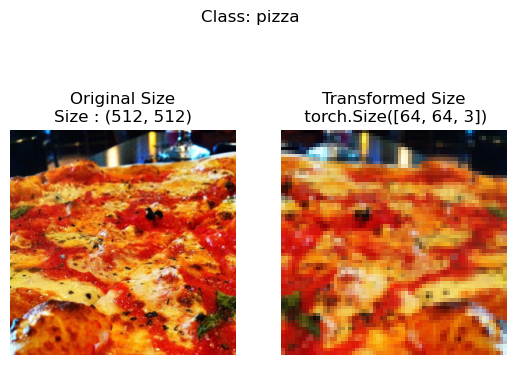

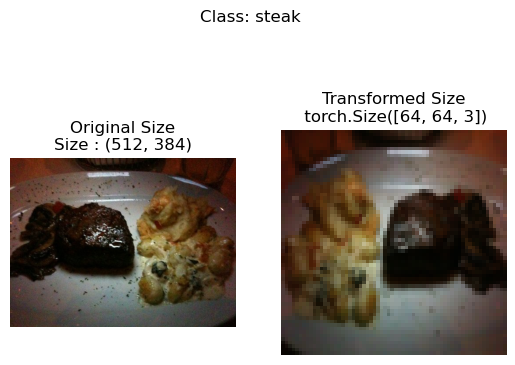

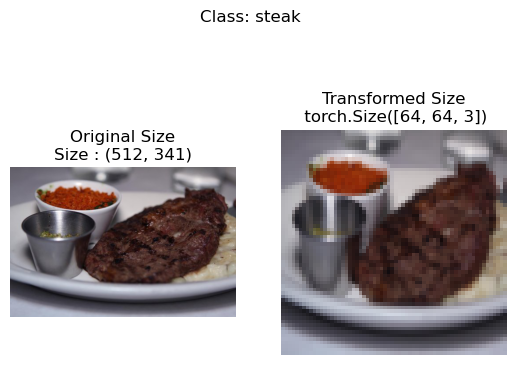

In [10]:
def plot_transformed_image(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from the path list of the image and loads/transforms
    them, then plots the orignal vs the transformed version.
    """

    if seed:
        random.seed(42)
    random_image_path = random.sample(image_paths, k=n) # gives n random paths

    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original Size\nSize : {f.size}')
            ax[0].axis(False)
            
            #transformed image
            transformed_image = transform(f).permute(1,2,0) # chw to hwc
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Size\n {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class: {image_path.parent.stem}')
            
plot_transformed_image(image_path_list, transform=data_transforms, seed=42)

## 4. Option 1: Loading all the images using `ImageFolder`

We can load image classification using `torchvision.datasets.ImageFolder`

We can use this because our folder is already in the standard image classification format.

train
'
'--pizza
    '
    '-<>.jpg
    '-<>.jpg
'--sushi
    '
    '-<>.jpg
    '-<>.jpg
'--steak
    '
    '-<>.jpg
    '-<>.jpg

In [11]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transforms,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 226
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# check the lengths of our datasets
len(train_data), len(test_data)

(226, 75)

In [15]:
# get one data
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

### 4.1. Visualize the data

In [16]:
# index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]

print(f'Image tensor:\n {img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Image label dtype: {type(label)}')

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original image shape: torch.Size([3, 64, 64])
Permuted image shape: torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

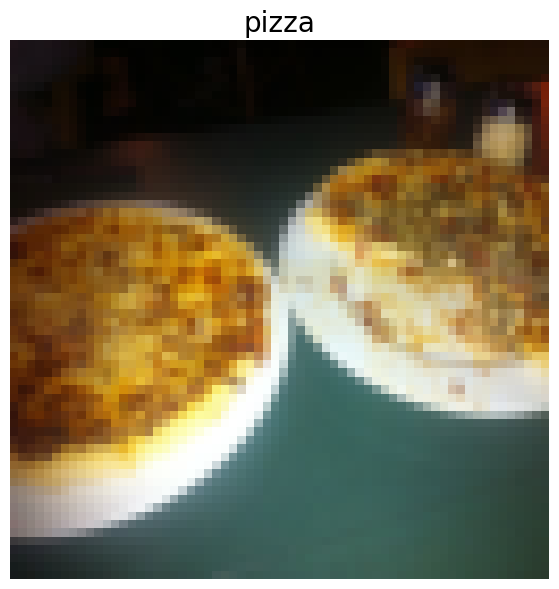

In [17]:
# to visualize the data, we have to change the order of the dimensions
# in matplotlib [hwc] not [chw]

img_permute = img.permute(1,2,0)

# Print out shapes: original and img_permute
print(f'Original image shape: {img.shape}')
print(f'Permuted image shape: {img_permute.shape}')

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=20)
plt.axis(False)

### 4.2 Turn datasets into DataLoaders

Dataloader will turn our `datasets` into `iterables`. And we can customize the `batch_size`, so our model can see `batch_size` images at a time.

In [18]:
from torch.utils.data import DataLoader

import os
print(f'Total CPU: {os.cpu_count()}')

Total CPU: 16


In [25]:
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), # the more the better
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11d9a26b0>,
 <torch.utils.data.dataloader.DataLoader at 0x11d9a30d0>)

In [26]:
# iterate through the dataloader
img, label = next(iter(train_dataloader))

# print img shape and label shape
print(f'Image Shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a custom `Dataset`

1. To be able to load images from file
2. To be able to get class names from the Dataset
3. To be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` our of almost anything
* Not limited to PyTorch pre-buildt `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't nmean it will work.
* Using a custom `Dataset